# Henon - Heiles System 
A hamiltonian system that exhibits the challenging regime of mix of order and chaos.
$$
H(q_{1},q_{2},p_{1},p_{2}) = \frac{1}{2}(q_{1}^{2}+q_{2}^{2}+p_{1}^{2}+p_{1}^{2})+\lambda(q_{1}^{2}q_{2}-\frac{q_{2}^{3}}{3})
$$
We'll try and train a Hamiltonian NN and a baseline NN to learn this system

In [ ]:
import matplotlib.pyplot as plt
import torch, time, sys
import numpy as np
from math import sqrt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = 'TrainedNetworks'
sys.path.append(EXPERIMENT_DIR)

from baseline_nn import BLNN
from hnn import HNN
from utils import  to_pickle, from_pickle
from data import DynamicalSystem
from tqdm import tqdm

## Set some notebook constants

In [ ]:
DPI = 300
FORMAT = 'pdf'
DSR = 0.1

def get_args():
    return {'input_dim': 4, # two bodies, each with q_x, q_y, p_z, p_y
         'hidden_dim': [200,200],
         'learn_rate': 1e-3,
         'input_noise': 0.0,
         'batch_size': 512,
         'epochs': 1,
         'hamiltonian': "(q1**2+q2**2+p1**2+p2**2)/(2)+ (q1**2*q2 - (q2**3)/(3))",
         'energy': 0.15, # Range [0.02 0.16]
         'integrator': "RK45", #[RK45, RK4, Symplectic]
         'verbose': True,
         'name': 'Henon_Heiles_DSR_{}'.format(DSR),
         'seed': 957,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Instantiating args 

In [ ]:
args = ObjectView(get_args())

## Visualize one example from dataset

In [26]:

# seeting a fixed seed 
np.random.seed(args.seed)

tspan = [0,500] # integration time 

tpoints = int(tspan[1]*(1.0/DSR)) # resolution of time series 
print('No. of orbit points : {}'.format(tpoints))

state_symbols = ['q1','q2','p1','p2']

# Instantiating the dynamical systems using args
sys = DynamicalSystem(sys_hamiltonian=args.hamiltonian,state_symbols=state_symbols,
                      tspan=tspan,timesteps=tpoints,integrator=args.integrator,
                      symplectic_order=4)

# sampling consistent initial conditions using energy expression 
result = False
while not result:
    with np.errstate(invalid='raise'):
        try:
            r1, r2 = 4*np.random.random(2)-2
            angle = 2*np.pi*np.random.random()-np.pi
            if -1<r1<1 and -1<r2<1:
                continue
            else:
                q1, q2 = r1, r2
                p1 = 0.5*np.sin(angle)

                p2 = 0.5*np.cos(angle)

                result = True
        except FloatingPointError:
            continue

state = np.array([q1, q2, p1, p2])

print('Initial Condition : {}'.format(state))
print('Energy : {}'.format(sys.get_energy(state)))

orbit, settings = sys.get_orbit(state)

print('Shape of the orbit : {}'.format(orbit.shape))


No. of orbit points : 5000
Initial Condition : [ 1.61921222 -0.24478578  0.01178869 -0.49986101]
Energy : 0.4658841473646367
Shape of the orbit : (4, 5000)


## Visualizing a sample trajectory

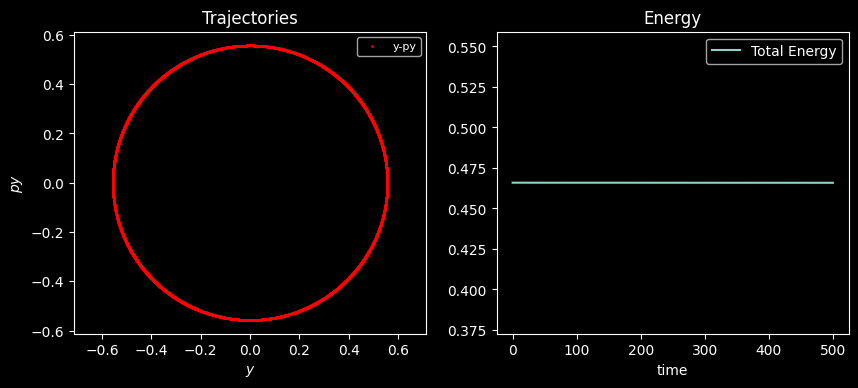

In [27]:
# draw trajectory
fig = plt.figure(figsize=[10,4], dpi=100)

# using dark background style sheet for all plots
plt.style.use('dark_background')

plt.subplot(1,2,1)
plt.title('Trajectories')
plt.plot(orbit[1,:], orbit[3,:],  '.r', label='y-py',markersize=2)
plt.axis('equal')
plt.xlabel('$y$') ; plt.ylabel('$py$')
plt.legend(fontsize=8, loc='best')

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
z = sys.get_energy(orbit)
plt.plot(settings['t_eval'], z, label='Total Energy')
plt.legend()
y_lim = (0.8*z.min(),1.2*z.max())
plt.ylim(y_lim)



plt.show()
#fig.savefig('{}/orbits-dataset_{}_nlayers_{}_energy_{}_integrator_{}.{}'.format(
#                                                    args.fig_dir,args.name,len(args.hidden_dim),
#                                                    args.energy,args.integrator,FORMAT))

## Load Trained models

In [29]:
def load_model(args, baseline=False):
    
    if baseline:
        output_dim = args.input_dim
        model = BLNN(args.input_dim, args.hidden_dim,output_dim,'Tanh')
    else:
        output_dim = 1
        nn_model = BLNN(args.input_dim, args.hidden_dim,output_dim,'Tanh')
        model = HNN(args.input_dim,baseline_model=nn_model)
    
    case = 'baseline' if baseline else 'hnn'
    #print('---->',case)
    path = "/content/OrderChaosHNN/TrainedNetworks/SquareTorus_DSR_0.1_nlayers_2-orbits-baseline_integrator_RK45_epochs_2_BatchSize_512.tar"
    print('----------->', path)
    model.load_state_dict(torch.load(path),strict=False)
    return model

args = ObjectView(get_args())
base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)
print('----->',base_model)
print('\n\n')
print('----->',hnn_model)

Using Tanh()...
ModuleList(
  (0): Linear(in_features=4, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
)
-----------> /content/OrderChaosHNN/TrainedNetworks/SquareTorus_DSR_0.1_nlayers_2-orbits-baseline_integrator_RK45_epochs_2_BatchSize_512.tar
Using Tanh()...
ModuleList(
  (0): Linear(in_features=4, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
)
-----------> /content/OrderChaosHNN/TrainedNetworks/SquareTorus_DSR_0.1_nlayers_2-orbits-baseline_integrator_RK45_epochs_2_BatchSize_512.tar
-----> BLNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
  )
  (last_layer): Linear(in_features=200, out_features=4, bias=False)
)



-----> HNN(
  (baseline_model): BLNN(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=200, bias=True)
      (1): Linear(in_features=200, out_features=200, bias=Tr

# What has the baseline learned?

In [30]:
# for integrating a vector field parameterized by a NN or HNN
def model_update(t, state, model):
    state = state.reshape(-1,4)
    deriv = np.zeros_like(state)
   
    x = torch.tensor( state, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv= dx_hat.detach().data.numpy()
    return deriv.reshape(-1)

### Integrate trajectories

In [31]:
print(sys.time_points)

5000


In [33]:

# calculating true trajectories
np.random.seed(57845)

sys.time_points = int(1/DSR)*(tspan[1])

sys.integrator ='RK45'

# sampling consistent initial conditions using energy expression 
result = False
while not result:
    with np.errstate(invalid='raise'):
        try:
            r1, r2 = 4*np.random.random(2)-2
            angle = 2*np.pi*np.random.random()-np.pi
            if -1<r1<1 and -1<r2<1:
                continue
            else:
                q1, q2 = r1, r2
                p1 = 0.5*np.sin(angle)

                p2 = 0.5*np.cos(angle)

                result = True
        except FloatingPointError:
            continue

state = np.array([q1, q2, p1, p2])


print('Starting State : {}'.format(state))
sys.external_update_fn = None ## Only used when forecasting with NN or HNN (not for true trajectories)
orbit, settings = sys.get_orbit(state)
print('Orbit Shape : {}'.format(orbit.shape))


Starting State : [-0.89291211  1.23272919  0.24680475  0.43484183]
Orbit Shape : (4, 5000)


In [34]:
# defining update function for baseline model 
update_fn = lambda t, y0: model_update(t, y0, base_model)
sys.external_update_fn = update_fn
sys.integrator = 'RK45'
# calculating baseline forecasts
base_orbit, settings = sys.get_orbit(state)
print('Starting State : {}'.format(state))
print('Orbit Shape : {}'.format(base_orbit.shape))

Using external  function...
Starting State : [-0.89291211  1.23272919  0.24680475  0.43484183]
Orbit Shape : (4, 5000)


### Draw trajectories

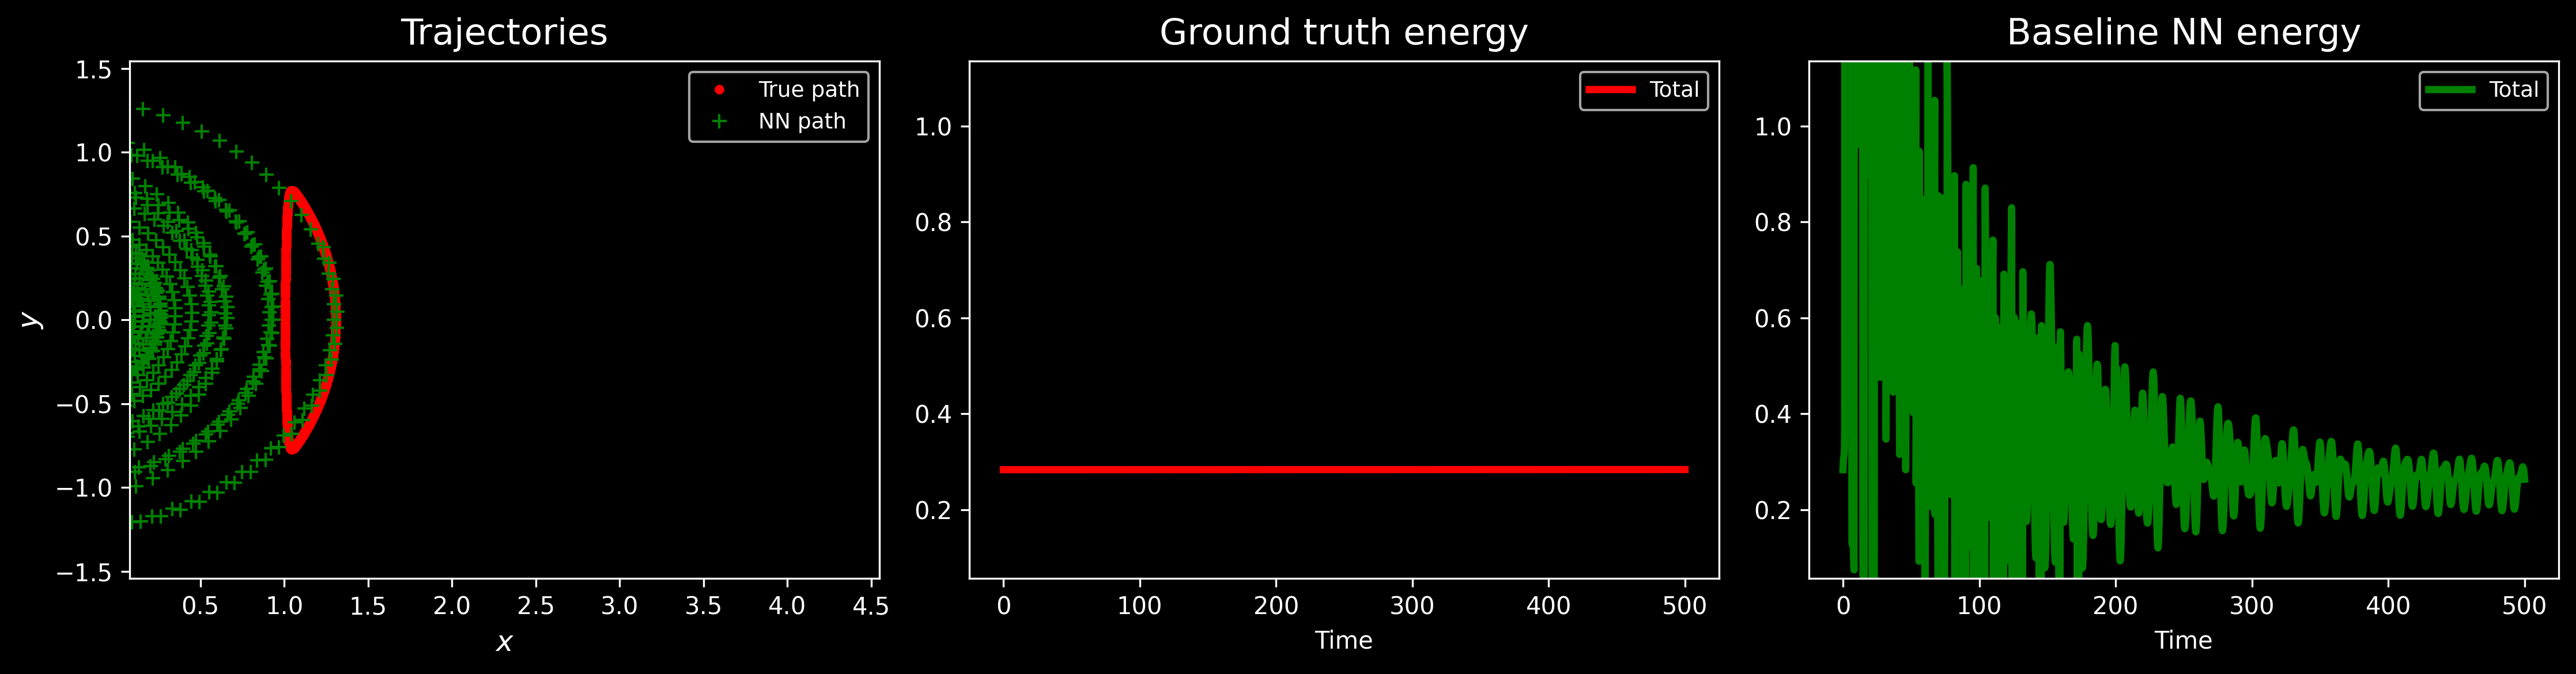

In [35]:
lw = 3 #linewidth
fs = 9 # font size
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=DPI)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['red', 'green']

plt.plot(orbit[1,:], orbit[3,:], '.', c=colors[0], label='True path', linewidth=lw)
plt.plot(base_orbit[1,:], base_orbit[3,:], '+', c=colors[1], label='NN path', linewidth=lw)
plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)
plt.xlim(2.0*np.min(orbit[1,:]), 2.0*np.max(orbit[1,:]))
plt.ylim(2.0*np.min(orbit[3,:]), 2.0*np.max(orbit[3,:]))

plt.subplot(1,3,2)
real_etot = sys.get_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_etot, 'r-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['tspan'])
ymin = 0.2*real_etot.min() 
ymax = 4*real_etot.max()
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], sys.get_energy(base_orbit), 'g-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['tspan'])
plt.ylim(ymin, ymax)
#plt.yscale('log')

plt.tight_layout() ; plt.show()
#fig.savefig('{}/orbits-baseline_{}_nlayers_{}integrator_{}.{}'.format(args.fig_dir, args.name,
#                                                len(args.hidden_dim),args.integrator, FORMAT))

## What has the HNN learned?

### Integrate trajectories

In [36]:
sys.integrator = 'RK45'
print('Starting State : {}'.format(state))

update_fn = lambda t, y0: model_update(t, y0, hnn_model)
sys.external_update_fn = update_fn
hnn_orbit, settings = sys.get_orbit(state)
print('Orbit Shape : {}'.format(hnn_orbit.shape))

Starting State : [-0.89291211  1.23272919  0.24680475  0.43484183]
Using external  function...
Orbit Shape : (4, 5000)


### Draw trajectories

<string>:3: RuntimeWarning: overflow encountered in exp


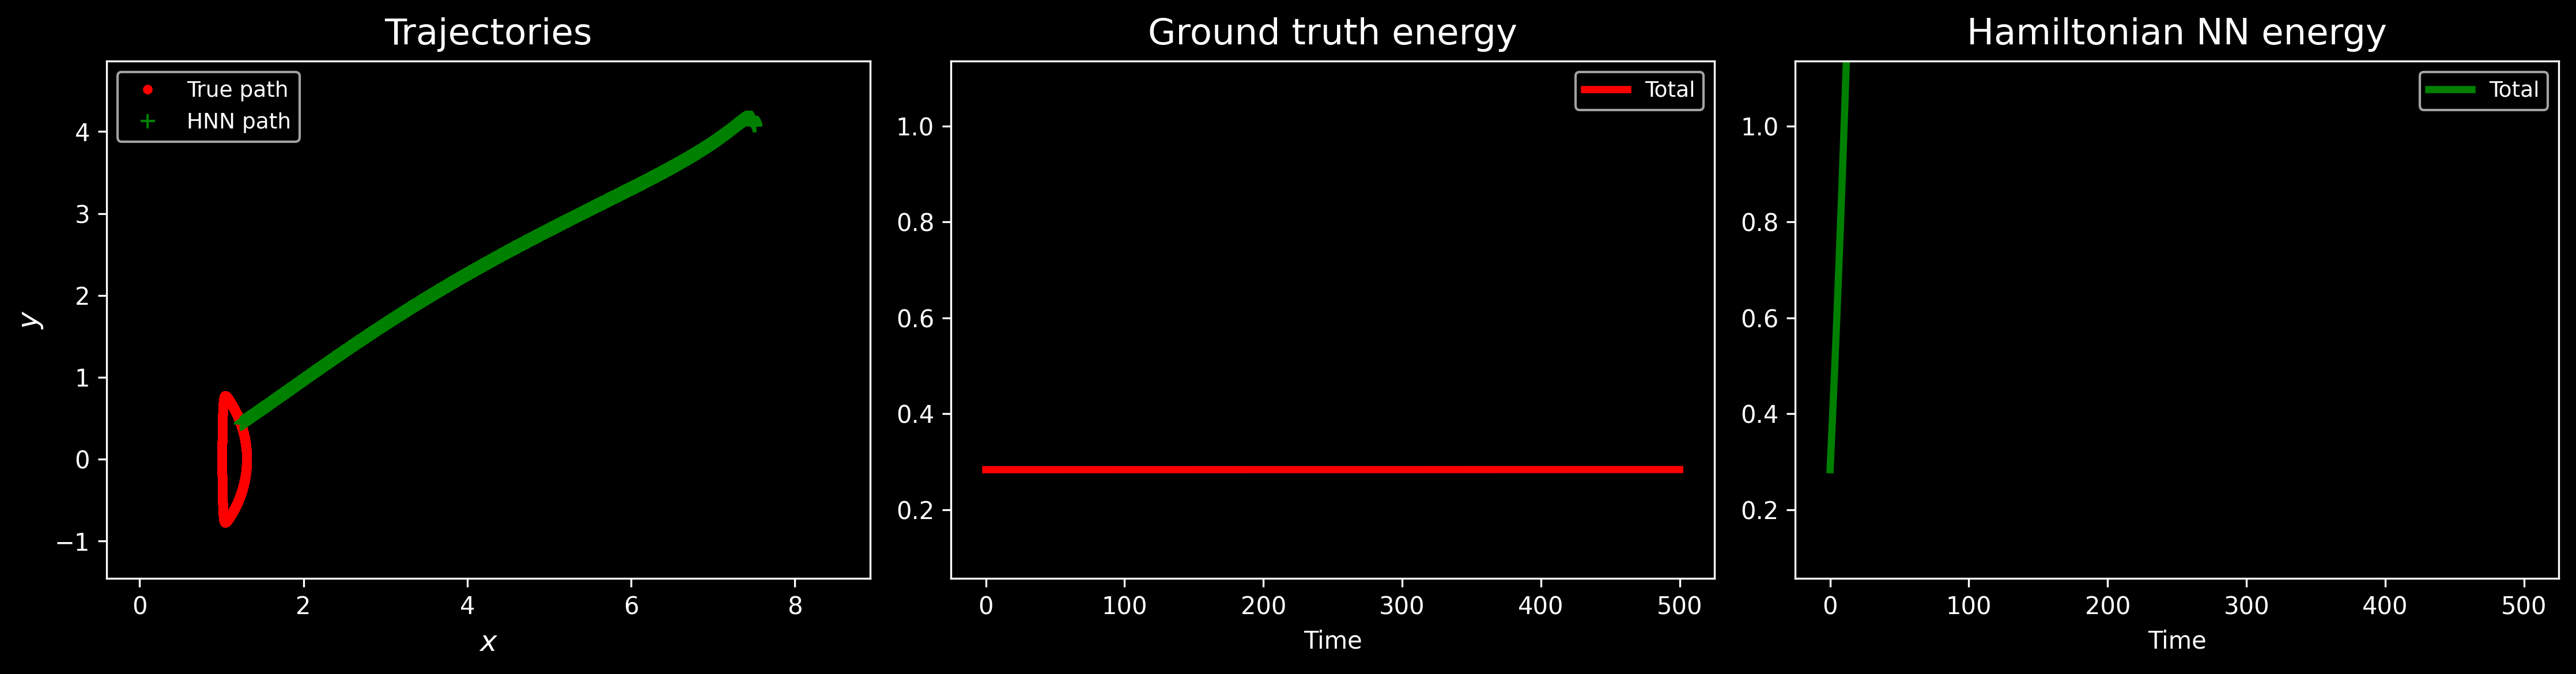

In [37]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12


fig = plt.figure(figsize=[15,4], dpi=DPI)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['red', 'green']

plt.plot(orbit[1,:], orbit[3,:], '.', c=colors[0], label='True path', linewidth=lw)
plt.plot(hnn_orbit[1,:], hnn_orbit[3,:], '+', c=colors[1], label='HNN path', linewidth=lw)
plt.xlim(2.0*np.min(orbit[1,:]), 2.0*np.max(orbit[1,:]))
plt.ylim(2.0*np.min(orbit[3,:]), 2.0*np.max(orbit[3,:]))

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_etot = sys.get_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_etot, 'r-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['t_span'])
ymin = 0.2*real_etot.min()
ymax = 4*real_etot.max()
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Hamiltonian NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], sys.get_energy(hnn_orbit), 'g-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
#fig.savefig('{}/orbits-hnn-{}_nlayers_{}_integrator_{}.{}'.format(args.fig_dir,args.name,
#                                                len(args.hidden_dim),args.integrator,FORMAT))

# How does the poincare section look like ?


In [ ]:
def get_poincare_section(orbit):
    '''
        Takes in an orbit (x,y,x_dot,y_dot) and spits out a poincare section (y,y_dot) as a tuple.
    '''
    x, y, x_dot, y_dot = orbit[0], orbit[1], orbit[2], orbit[3]
    y_poincare = []
    y_dot_poincare = []
    for i in range(len(x) - 1):
        if (x[i] * x[i + 1] < 0.0):
            y_poincare.append(0.5 * (y[i] + y[i + 1]))
            y_dot_poincare.append(0.5 * (y_dot[i] + y_dot[i + 1]))

    return y_poincare, y_dot_poincare

def get_random_intial_conditons(energy):
    result = False
    while not result:
        with np.errstate(invalid='raise'):
            try:
                q1, q2 = 0.3*(1-2*np.random.random(2))
                p1= 0.2*(1-2*np.random.random())
                p2 = abs(sqrt(2*(energy - (q1**2*q2 - q2**3/3.0))-(q1**2+q2**2+p1**2)))
                result = True 
            except FloatingPointError:
                continue 

    initial_state = np.array([q1, q2, p1, p2])
    return initial_state


In [ ]:
# calculates 'n' different true orbits corresponding to the same energy
n_orbits = 10
np.random.seed(13353)
energy = 0.1
orbit_set = []
sys.tspan = [1, 4000]
sys.time_points = 400000
sys.external_update_fn = None
for i in tqdm(range(n_orbits)):
    y0 = get_random_intial_conditons(energy)
    sol, t = sys.get_orbit(state=y0)
    orbit_set.append(sol)




100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


In [ ]:
# calculates 'n' different learned-hnn orbits corresponding to the same energy
hnn_orbit_set = []
np.random.seed(13353)
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
for i in tqdm(range(n_orbits)):
    sys.external_update_fn = update_fn
    y0 = get_random_intial_conditons(energy)
    sol, t = sys.get_orbit(state=y0)
    hnn_orbit_set.append(sol)

  0%|          | 0/10 [00:00<?, ?it/s]

Using external  function...


 10%|█         | 1/10 [00:51<07:41, 51.30s/it]

Using external  function...


 20%|██        | 2/10 [01:46<07:00, 52.59s/it]

Using external  function...


 30%|███       | 3/10 [02:42<06:13, 53.42s/it]

Using external  function...


 40%|████      | 4/10 [03:36<05:22, 53.68s/it]

Using external  function...


 50%|█████     | 5/10 [04:33<04:32, 54.55s/it]

Using external  function...


 60%|██████    | 6/10 [05:30<03:42, 55.52s/it]

Using external  function...


 70%|███████   | 7/10 [06:25<02:45, 55.12s/it]

Using external  function...


 80%|████████  | 8/10 [07:21<01:50, 55.42s/it]

Using external  function...


 90%|█████████ | 9/10 [08:12<00:54, 54.15s/it]

Using external  function...


100%|██████████| 10/10 [09:05<00:00, 54.56s/it]


In [ ]:
# calculates 'n' different learned-baseline orbits corresponding to the same energy
baseline_orbit_set = []
np.random.seed(13353)
update_fn = lambda t, y0: model_update(t, y0, base_model)
for i in tqdm(range(n_orbits)):
    sys.external_update_fn = update_fn
    y0 = get_random_intial_conditons(energy)
    sol, t = sys.get_orbit(state=y0)
    baseline_orbit_set.append(sol)

  0%|          | 0/10 [00:00<?, ?it/s]

Using external  function...


 10%|█         | 1/10 [00:02<00:21,  2.39s/it]

Using external  function...


 20%|██        | 2/10 [00:05<00:20,  2.62s/it]

Using external  function...


 30%|███       | 3/10 [00:09<00:20,  2.99s/it]

Using external  function...


 40%|████      | 4/10 [00:12<00:18,  3.06s/it]

Using external  function...


 50%|█████     | 5/10 [00:16<00:15,  3.17s/it]

Using external  function...


 60%|██████    | 6/10 [00:18<00:11,  2.92s/it]

Using external  function...


 70%|███████   | 7/10 [00:22<00:09,  3.26s/it]

Using external  function...


 80%|████████  | 8/10 [00:24<00:05,  2.86s/it]

Using external  function...


 90%|█████████ | 9/10 [00:26<00:02,  2.78s/it]

Using external  function...


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


In [ ]:
# get the poincare sections for corresponding true orbits 
y = []
y_dot = []
for i in range(n_orbits):
    y_tmp, y_dot_tmp = get_poincare_section(orbit_set[i])
    y.append(y_tmp)
    y_dot.append(y_dot_tmp)


In [ ]:
# get the poincare sections for corresponding hnn orbits 
hnn_y = []
hnn_y_dot = []
for i in range(n_orbits):
    y_tmp, y_dot_tmp = get_poincare_section(hnn_orbit_set[i])
    hnn_y.append(y_tmp)
    hnn_y_dot.append(y_dot_tmp)

In [ ]:
# get the poincare sections for corresponding baseline orbits 
baseline_y = []
baseline_y_dot = []
for i in range(n_orbits):
    y_tmp, y_dot_tmp = get_poincare_section(baseline_orbit_set[i])
    baseline_y.append(y_tmp)
    baseline_y_dot.append(y_dot_tmp)

# Plotting the poincare section of the true trajectories 

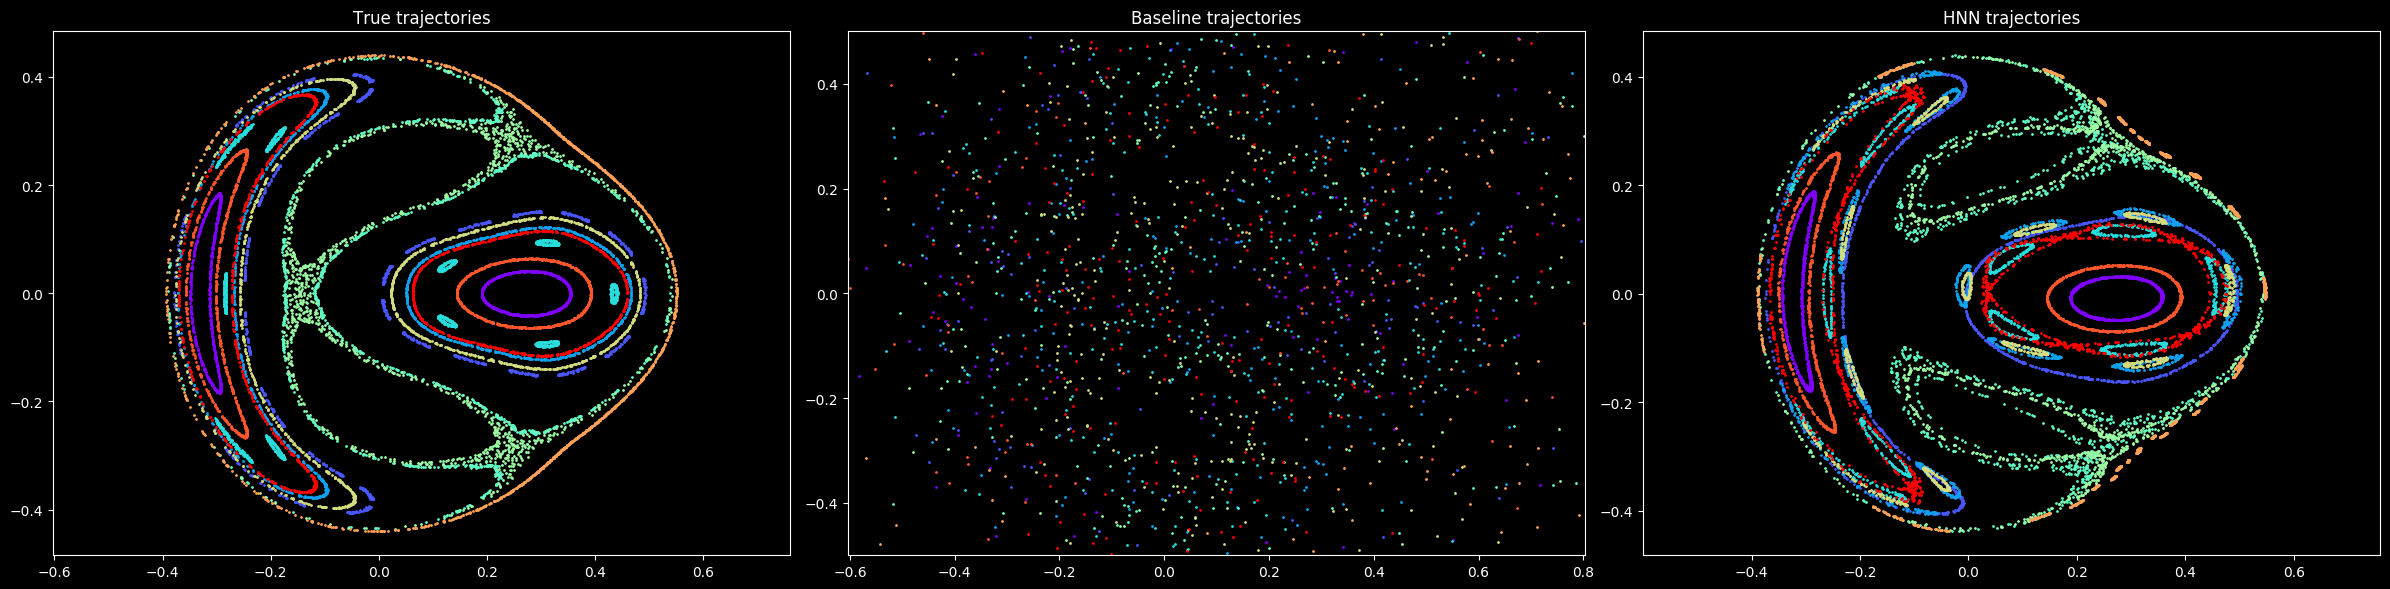

In [ ]:
import matplotlib
from matplotlib import cm
colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_orbits))
fig = plt.figure(figsize=[24,6], dpi=100)
plt.subplot(1,3,1)

plt.title('True trajectories')
for i in range(n_orbits):
    plt.plot(y[i], y_dot[i], '.', markersize=2, color=colors[i])
plt.axis('equal')


plt.subplot(1,3,2)
plt.title('Baseline trajectories')
for i in range(n_orbits):
    plt.plot(baseline_y[i], baseline_y_dot[i], '.', markersize=2, color=colors[i])
plt.axis('equal')
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.7])

plt.subplot(1,3,3)
plt.title('HNN trajectories')
for i in range(n_orbits):
    plt.plot(hnn_y[i], hnn_y_dot[i], '.', markersize=2, color=colors[i])
plt.axis('equal')

plt.tight_layout() ; plt.show()
#fig.savefig('{}/{}_nlayers_{}_poincare_integrator_{}.{}'.format(args.fig_dir,args.name,
#                                       len(args.hidden_dim),args.integrator, FORMAT))